In [1]:
import torch # '2.0.0+cpu'
import torch.nn.functional as F # '2.0.0+cpu'
import matplotlib.pyplot as plt # '3.7.1'


this layer is useful for upsampling without deconvolution layers, we can do the upsampling inside a network with normal convolution layers followed by a pixell shuffle layer. This is useful for super resolution tasks.

this layer was proposed in this paper: https://arxiv.org/pdf/1609.05158, for the task of super-resolution

today this can be used for upsampling the output of a network to a desired size, or inside a network to match resolution of feature maps

In [2]:
batch_size = 1
in_channels = 1
upscale_factor = 2 # 2x upscaling
C = in_channels * (upscale_factor ** 2)

H, W = 4, 4

lr_tensor = torch.randn(batch_size, C, H, W)

pixel_shuffle = torch.nn.PixelShuffle(upscale_factor) # this is the importante layer here

hr_tensor = pixel_shuffle(lr_tensor)

print("tensor base shape: ", lr_tensor.shape)
print("High-resolution tensor shape: ", hr_tensor.shape)

tensor base shape:  torch.Size([1, 4, 4, 4])
High-resolution tensor shape:  torch.Size([1, 1, 8, 8])


demonstration of its equivalence with transposed convolution 

we have the pytorch implementation of the example given here: https://arxiv.org/pdf/1609.07009

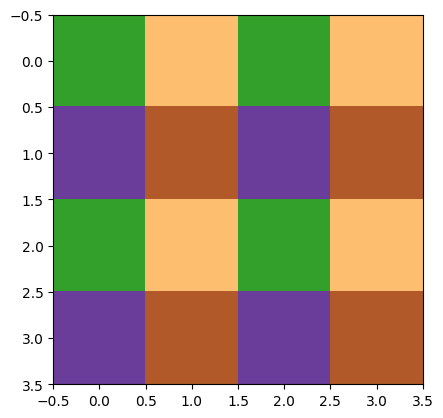

In [3]:
image = torch.ones(1, 1, 4, 4)

kernel_deconv = torch.tensor(
    [[1,2,1,2],
     [3,4,3,4],
     [1,2,1,2],
     [3,4,3,4]]
).float()

plt.imshow(kernel_deconv.numpy(), vmin=0, vmax=4, cmap='Paired')

In [12]:
image.shape, kernel_deconv.unsqueeze(0).unsqueeze(0).shape

(torch.Size([1, 1, 4, 4]), torch.Size([1, 1, 4, 4]))

torch.Size([1, 1, 8, 8])


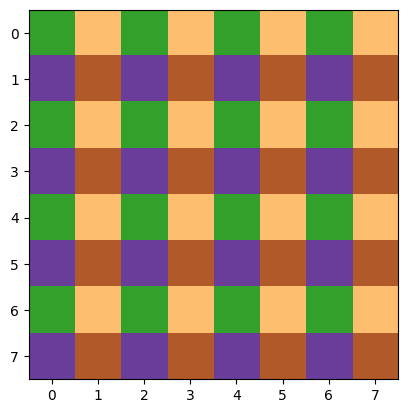

In [84]:
# pad as in the paper
# this padding is just for the example, with other paddings the demostration is equivalent
image2 = F.pad(image, (0, 1, 0, 1), value=1)

# deconv
deconv = F.conv_transpose2d(image2, kernel_deconv.unsqueeze(0).unsqueeze(0), stride=(2,2), padding=2)
print(deconv.shape)

plt.imshow(deconv.squeeze().numpy(), vmin=0, cmap='Paired')

torch.Size([1, 4, 4, 4])
torch.Size([1, 1, 8, 8])


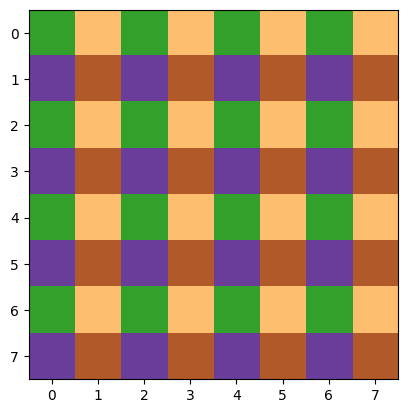

In [95]:
tensor1 = torch.ones(1, 2, 2)
tensor2 = torch.ones(1, 2, 2) * 2
tensor3 = torch.ones(1, 2, 2) * 3
tensor4 = torch.ones(1, 2, 2) * 4

kernelconv = torch.cat((tensor1, tensor2, tensor3, tensor4), dim=0)

# pad as in the paper
image2 = F.pad(image, (0, 1, 0, 1), value=1)

# convolution + pixel shuffle
result = F.conv2d(image2, kernelconv.unsqueeze(1), stride=1)
pixel_shuffle = torch.nn.PixelShuffle(2)


print(result.shape)
out_shuffle = pixel_shuffle(result)
print(out_shuffle.shape)

plt.imshow(out_shuffle.squeeze().numpy(), vmin=0, cmap='Paired')

In [100]:
torch.flatten(kernel_deconv).shape, torch.flatten(kernelconv).shape

# they have the same number of weights in his kernels!

(torch.Size([16]), torch.Size([16]))

In [86]:
deconv - out_shuffle

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.]]]])

thus, they are exactly equivalent